In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys
from pyne import nucname
from pyne.material import Material

/Users/13b/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/Users/13b/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


In [4]:
# get sqlite cursor
filename = '../../db/1yr.sqlite'
con = lite.connect(filename)
# allows indexing with column name
con.row_factory = lite.Row
cur = con.cursor()

# Finding the Average Assembly and its Composition 

In [5]:
# first, find the average composition and recipe 
average_burnup = cur.execute('SELECT avg(discharge_burnup) FROM discharge').fetchone()[0]
average_enrichment = cur.execute('SELECT avg(initial_enrichment) FROM discharge').fetchone()[0]
print('AVG BURNUP: %f MWD/MTHM \nAVG ENRICHMENT: %f wt%% U235' %(average_burnup, average_enrichment))

AVG BURNUP: 36169.381303 MWD/MTHM 
AVG ENRICHMENT: 3.392045 wt% U235


In [6]:
# find assembly closest to this value:
min_diff_assem_id = cur.execute('SELECT assembly_id, min(abs(discharge_burnup - %f) + abs(initial_enrichment - %f)* 10000) '
                                'FROM discharge' %(average_burnup, average_enrichment)).fetchone()[0]
print(min_diff_assem_id)

324192


In [7]:
# how different is this assembly from the average?
chosen_assem = cur.execute('SELECT * FROM discharge WHERE assembly_id = %i' %min_diff_assem_id).fetchall()
burnup = chosen_assem[0]['discharge_burnup']
enrichment = chosen_assem[0]['initial_enrichment']

print(burnup)
print(enrichment)

# print error with the average value:
print('ERROR:')
enr_err = 100 * (average_enrichment - enrichment) / average_enrichment
bur_err = 100 * (average_burnup - burnup) / average_burnup
print('ENRICHMENT: %f %% \nBURNUP %f %%' %(enr_err, bur_err))

36172.0
3.394
ERROR:
ENRICHMENT: -0.057637 % 
BURNUP -0.007240 %


In [8]:
# save this assembly's composition to a dictionary
recipe = {}
total_mass = 0
for row in chosen_assem:
    isotope = nucname.name(row['isotope'])
    mass = float(row['total_mass_g'])
    total_mass += mass
    recipe[isotope] = mass

# normalize values:
for iso in recipe:
    print('%s : %f' %(iso, recipe[iso] / total_mass))
    recipe[iso] = recipe[iso] / total_mass

Th230 : 0.000000
Th229 : 0.000000
U238 : 0.965954
U236 : 0.004462
Zr93 : 0.000869
Y90 : 0.000000
Zr95 : 0.000001
U233 : 0.000000
U232 : 0.000000
Th232 : 0.000000
U235 : 0.010470
U234 : 0.000176
Pu239 : 0.007558
Pu240 : 0.002645
Pu241 : 0.001752
Pu242 : 0.000589
Ru106 : 0.000083
Sb124 : 0.000000
Se79 : 0.000005
Sb125 : 0.000010
Ru103 : 0.000000
Ra226 : 0.000000
Pu244 : 0.000000
Sn126 : 0.000024
Sm151 : 0.000016
Tc99 : 0.000870
Sr90 : 0.000552
Am241 : 0.000164
Am242M : 0.000001
C14 : 0.000000
Am243 : 0.000152
Cm242 : 0.000005
Cf251 : 0.000000
Cm244 : 0.000055
Cm243 : 0.000001
Cf249 : 0.000000
Ce144 : 0.000120
Cm245 : 0.000004
Cm246 : 0.000000
Cm247 : 0.000000
Cs134 : 0.000105
Cm248 : 0.000000
Cs137 : 0.001321
Cs135 : 0.000570
Eu154 : 0.000031
Eu152 : 0.000000
Kr85 : 0.000030
I129 : 0.000182
Nb94 : 0.000000
Np237 : 0.000559
Nb95 : 0.000001
Eu155 : 0.000008
H3 : 0.000000
Pa231 : 0.000000
Pd107 : 0.000269
Pm147 : 0.000142
Pu238 : 0.000241
Ag108M : 0.000000
Ag110M : 0.000000
Ac227 : 0.000000

# We store all the assemblies in a dictionary, one with the composition with UNF-ST&DARDS, and the other with recipe composition

In [9]:
### This can be done but takes way too long to actually get each assembly
def get_assembly_dict(cur):
    """ gets assembly evalution times, isotope, total_mass_g and total mass"""
    assem_dict = {}
    query = cur.execute('SELECT * FROM discharge').fetchall()
    count = 0
    percent_done = 0
    for row in query:
        iso = nucname.name(row['isotope'])
        mass = float(row['total_mass_g'])
        if row['assembly_id'] not in assem_dict.keys():
            # first of the assembly input data, initialize assem_dict[assembly_id] dict
            assem_dict[row['assembly_id']] = {'date': row['evaluation_date']}
            assem_dict[row['assembly_id']]['mass'] = 0
            assem_dict[row['assembly_id']]['comp'] = {iso: mass}
        else:
            assem_dict[row['assembly_id']]['comp'][iso] = mass
            assem_dict[row['assembly_id']]['mass'] += mass
        count += 1
        if len(query) // 50 == count:
            percent_done += 2
            print('%s %% DONE' %percent_done)
    return assem_dict

In [10]:
def get_lump_and_recipe_dict(cur):
    lump_dict = {}
    recipe_dict = {}
    query = cur.execute('SELECT evaluation_date, isotope, sum(total_mass_g) FROM discharge '
                        'GROUP BY evaluation_date, isotope').fetchall()
    for row in query:
        iso = nucname.name(row['isotope'])
        mass = float(row['sum(total_mass_g)'])
        if row['evaluation_date'] not in lump_dict.keys():
            lump_dict[row['evaluation_date']] = {}
            lump_dict[row['evaluation_date']]['mass'] = mass
            lump_dict[row['evaluation_date']]['comp'] = {iso: mass}
            
            recipe_dict[row['evaluation_date']] = {}
            recipe_dict[row['evaluation_date']]['mass'] = mass
            recipe_dict[row['evaluation_date']]['comp'] = recipe
        else:
            lump_dict[row['evaluation_date']]['comp'][iso] = mass
            lump_dict[row['evaluation_date']]['mass'] += mass
            
            recipe_dict[row['evaluation_date']]['mass'] += mass
    
    # normalize comp values:
    for key, value in lump_dict.items():
        for key2, value2 in lump_dict[key]['comp'].items():
            lump_dict[key]['comp'][key2] = lump_dict[key]['comp'][key2] / lump_dict[key]['mass']
    
    print('DONE')
    return lump_dict, recipe_dict


In [11]:
# this takes a while:
lump_dict, recipe_dict = get_lump_and_recipe_dict(cur)

DONE


# Then we convert the assembly to `pyne` material, for decay and analysis

In [12]:
def attach_pyne_material(assem_dict):
    for key, value in assem_dict.items():
        pyne_mat = Material(value['comp'], value['mass'])
        assem_dict[key]['mat'] = pyne_mat
    return assem_dict

In [13]:
lump_dict = attach_pyne_material(lump_dict)
recipe_dict = attach_pyne_material(recipe_dict)

# Then we decay the assemblies to 2020:

In [14]:
def find_diff_time_secs(year, month, day, evaluation_date):
    # the UNF-ST&DARDS data format is YYYY-MM-DD
    ev_year = int(evaluation_date[:4])
    ev_month = int(evaluation_date[5:7])
    ev_day = int(evaluation_date[8:])
    
    dyear = 0
    dmonth = 0
    dday = day - ev_day
    if dday < 0:
        dmonth -= 1
        dday += 30
    dmonth += month - ev_month
    if dmonth < 0:
        dyear -= 1
        dmonth += 12
    dyear += year - ev_year
    if dyear < 0:
        raise ValueError('Cannot go back in time man')
    
    time_in_sec = dyear * (365 * 24 * 3600) + dmonth * (30 * 24 * 3600) + dday * (24 * 3600)
    return time_in_sec

In [15]:
def decay_assemblies(assem_dict):
    # just put the pyne materials in there, other categories are unnecessary
    decayed_dict = {}
    for key, value in assem_dict.items():
        # to 2020-07-01
        decay_time = find_diff_time_secs(2020, 7, 1, key)
        decayed_dict[key] = {}
        decayed_dict[key]['mass'] = assem_dict[key]['mass']
        decayed_dict[key]['mat'] = assem_dict[key]['mat'].decay(decay_time)
    return decayed_dict

In [16]:
decayed_lump_dict = decay_assemblies(lump_dict)

decayed_recipe_dict = decay_assemblies(recipe_dict)

# We also import 2020-cooled data from UNF-ST&DARDS

In [17]:
data_2020 = np.genfromtxt('2020_comp.csv', delimiter=",", dtype=None)
data_dict = {}
data_dict['2020-07-01'] = {'mass': 0, 'comp': {}}
for data in data_2020:
    # in grams
    data_dict['2020-07-01']['comp'][data[0].decode('utf-8').replace('-', '')] = data[1] * 1e3
    
# normalize:
norm = sum(data_dict['2020-07-01']['comp'].values())
data_dict['2020-07-01']['mass'] = norm
for key, value in data_dict['2020-07-01']['comp'].items():
    data_dict['2020-07-01']['comp'][key] = value / norm

# add pyne material
data_dict['2020-07-01']['mat'] = Material(data_dict['2020-07-01']['comp'], data_dict['2020-07-01']['mass'])

/Users/13b/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


# We also import 1 year-cooled data from UNF-ST&DARDS

In [18]:
data_1yr = np.genfromtxt('1yr_comp.csv', delimiter=",", dtype=None)
data_dict2 = {}
data_dict2['1yr'] = {'mass': 0, 'comp': {}}
for data in data_1yr:
    # in grams
    data_dict2['1yr']['comp'][data[0].decode('utf-8').replace('-', '')] = data[1] * 1e3
    
# normalize:
norm = sum(data_dict2['1yr']['comp'].values())
data_dict2['1yr']['mass'] = norm
for key, value in data_dict2['1yr']['comp'].items():
    data_dict2['1yr']['comp'][key] = value / norm

# add pyne material
data_dict2['1yr']['mat'] = Material(data_dict2['1yr']['comp'], data_dict2['1yr']['mass'])

/Users/13b/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


# Then we compare the metrics:

In [19]:
import math

def nansum(dictionary):
    summ = 0 
    for key, value in dictionary.items():
        # skip metastable isotopes
        if str(key)[-1] == '1':
            continue
        if not math.isnan(value):
             summ += value
    return summ

def decay_heatz(assem_dict, time=0):
    total_heat = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        total_heat += nansum(after.decay_heat())
    return total_heat

def total_massz(assem_dict, time=0):
    total_mass = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        total_mass += value['mass']
    return total_mass

def activityz(assem_dict, time=0):
    activity = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        activity += nansum(after.activity())
    return activity

def isotopics(assem_dict, time=0):
    iso_dict = {}
    for key, value in assem_dict.items():
        for key2, value2 in value['mat'].mult_by_mass().items():
            if key2 not in iso_dict.keys():
                iso_dict[key2] = value2
            else:
                iso_dict[key2] += value2
    return iso_dict


In [20]:
post_lump = isotopics(decayed_lump_dict)
post_recipe = isotopics(decayed_recipe_dict)
pre_lump = isotopics(lump_dict)
pre_recipe = isotopics(recipe_dict)
post_data = isotopics(data_dict)
pre_data = isotopics(data_dict2)

In [21]:
# check pu-239 amount
# total mass -> should be the same
print('UNIT: T')

print('\nPost-decay')
print(post_lump[942390000] * 1e-6) 
print(post_recipe[942390000] * 1e-6)

print('\nPre-decay')
print(pre_lump[942390000] * 1e-6)
print(pre_recipe[942390000] * 1e-6)

print('\nData')
print(post_data[942390000] * 1e-6)
print(pre_data[942390000] * 1e-6)

UNIT: T

Post-decay
520.5243187492008
514.2153744519587

Pre-decay
520.8168827414128
514.5154422461604

Data
520.5033843020661
520.8168827414328


In [22]:
# check cs137 amount
print('CS 137')
print('UNIT: T')

print('\nPost-decay')
print(post_lump[551370000] * 1e-6) 
print(post_recipe[551370000] * 1e-6)

print('\nPre-decay')
print(pre_lump[551370000] * 1e-6)
print(pre_recipe[551370000] * 1e-6)

print('\nData')
print(post_data[551370000] * 1e-6)
print(pre_data[551370000] * 1e-6)

CS 137
UNIT: T

Post-decay
59.23121322194579
54.77074253847175

Pre-decay
92.67789281584608
89.93929878463527

Data
59.198813954451914
92.67789281584886


In [23]:
# check cs137 amount
print('U235')
print('UNIT: T')

print('\nPost-decay')
print(post_lump[922350000] * 1e-6) 
print(post_recipe[922350000] * 1e-6)

print('\nPre-decay')
print(pre_lump[922350000] * 1e-6)
print(pre_recipe[922350000] * 1e-6)

print('\nData')
print(post_data[922350000] * 1e-6)
print(pre_data[922350000] * 1e-6)

U235
UNIT: T

Post-decay
771.4277121073793
713.0780731879

Pre-decay
771.1020596111706
712.7471110021237

Data
771.3974311902376
771.1020596111667


In [24]:
# total mass -> should be the same
print('UNIT: T')

print('\nPost-decay')
print(total_massz(decayed_lump_dict) * 1e-6) 
print(total_massz(decayed_recipe_dict) * 1e-6)

print('\nPre-decay')
print(total_massz(lump_dict) * 1e-6)
print(total_massz(recipe_dict) * 1e-6)

print('\nData')
print(total_massz(data_dict) * 1e-6)
print(total_massz(data_dict2) * 1e-6)

UNIT: T

Post-decay
68072.03038959576
68072.03038959576

Pre-decay
68072.03038959576
68072.03038959576

Data
67984.97457236807
68072.03038959604


In [47]:
print('UNIT: MW')
print('\nPost-decay')
print(decay_heatz(decayed_lump_dict)) 
print(decay_heatz(decayed_recipe_dict))
print((decay_heatz(decayed_lump_dict) -decay_heatz(decayed_recipe_dict)) / decay_heatz(decayed_lump_dict))

print('\nPre-decay')
print(decay_heatz(lump_dict))
print(decay_heatz(recipe_dict))

print('\nData')
print(decay_heatz(data_dict))
print(decay_heatz(data_dict2))

UNIT: MW

Post-decay
61.314410524366686
53.90641038572524
0.12081988679802226

Pre-decay
279.53506225378135
255.23577956568477

Data
61.10359664916922
279.53506225378095


In [48]:
print('UNIT: Bq')
print('\nPost-decay')
print(activityz(decayed_lump_dict))
print(activityz(decayed_recipe_dict))
print( (activityz(decayed_lump_dict) - activityz(decayed_recipe_dict)) / activityz(decayed_lump_dict) )

print('\nPre-decay')
print(activityz(lump_dict))
print(activityz(recipe_dict))

print('\nData')
print(activityz(data_dict))
print(activityz(data_dict2))

UNIT: Bq

Post-decay
6.762448428754226e+20
6.337963861559325e+20
0.0627708398322084

Pre-decay
3.9134422027352555e+21
3.807563773396736e+21

Data
6.745408869011487e+20
3.913442202735231e+21


# Checking that our results match the data, we do a direct comparison between the decayed material using UNF-ST&DARDS and an Avg. Recipe

In [27]:
# lump the materials to one material to make this easier
def lump_dict_to_mat(assem_dict):
    out_mat = Material({'H1':1},1e-6)
    for key, val in assem_dict.items():
        out_mat = out_mat + assem_dict[key]['mat']
    return out_mat

In [28]:
decayed_lump_mat = lump_dict_to_mat(decayed_lump_dict)
decayed_recipe_mat = lump_dict_to_mat(decayed_recipe_dict)

In [29]:
z = decayed_lump_mat.decay_heat()
for key, val in z.items():
    print('%s: %f' %(key,val))

10010000: 0.000000
10030000: 0.000363
20030000: 0.000000
60140000: 0.000010
70140000: 0.000000
340790000: 0.000002
350790000: 0.000000
360830000: 0.000000
360850000: 0.369539
370850000: 0.000000
380900000: 3.860757
390900000: 18.402357
400900000: 0.000000
400930000: 0.000017
400950000: 0.000000
410930000: 0.000000
410940000: 0.000000
410950000: 0.000000
420940000: 0.000000
420950000: 0.000000
430990000: 0.000520
440990000: 0.000000
441010000: 0.000000
441030000: 0.000000
441060000: 0.001125
451030000: 0.000000
451050000: 0.000000
451060000: 0.181868
461050000: 0.000000
461060000: 0.000000
461070000: 0.000001
461080000: 0.000000
471070000: 0.000000
471080001: 15809720677157.234375
471090000: 0.000000
471100001: 6712512533.467713
481130000: 0.000000
491130000: 0.000000
491150000: 0.000000
501150000: 0.000000
501260000: 0.000033
511240000: 0.000000
511250000: 0.075505
511260000: 0.000396
521240000: 0.000000
521250000: 0.000000
521260000: 0.000000
521270000: 0.000000
531270000: 0.000000
53

In [30]:
def plot_decay_heat(mat, start_year, end_year, n_grid=100):
    heat_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        heat_array[index] = nansum(decayed.decay_heat())
    return time_axis, heat_array

def plot_activity(mat, start_year, end_year, n_grid=100):
    heat_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        heat_array[index] = nansum(decayed.activity())
    return time_axis, heat_array


In [44]:
# decay heat at discrete times

# to 2100
t_to_2100 = 80 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_2100).decay_heat())
rec = nansum(decayed_recipe_mat.decay(t_to_2100).decay_heat())
print(acc)
print(rec)
print((acc-rec)/acc)
print('\n')

t_to_3100 = 1080 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_3100).decay_heat())
rec = nansum(decayed_recipe_mat.decay(t_to_3100).decay_heat())
print(acc)
print(rec)
print((acc-rec)/acc)
print('\n')


24.278657937054568
23.63935117680674
0.026332046932137226


4.720085142701878
4.836015191702174
-0.024561008010532424




In [45]:
# activity at discrete times

# to 2100
t_to_2100 = 80 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_2100).activity())
rec = nansum(decayed_recipe_mat.decay(t_to_2100).activity())
print(acc)
print(rec)
print((acc-rec)/acc)
print('\n')


t_to_3100 = 1080 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_3100).activity())
rec = nansum(decayed_recipe_mat.decay(t_to_3100).activity())
print(acc)
print(rec)
print((acc-rec)/acc)
print('\n')


9.284691583522844e+19
8.76546183622094e+19
0.05592320893279417


5.541897853623782e+18
5.65404302387209e+18
-0.02023587825152304




In [31]:
time_acc, heat_acc = plot_decay_heat(decayed_lump_mat, 2020, 3100)
time_rec, heat_rec = plot_decay_heat(decayed_recipe_mat, 2020, 3100)

time_acc, act_acc = plot_activity(decayed_lump_mat, 2020, 3100)
time_rec, act_rec = plot_activity(decayed_recipe_mat, 2020, 3100)

In [49]:
err_heat = (heat_acc - heat_rec) / heat_acc * 100
err_act = (act_acc - act_rec) / act_acc * 100

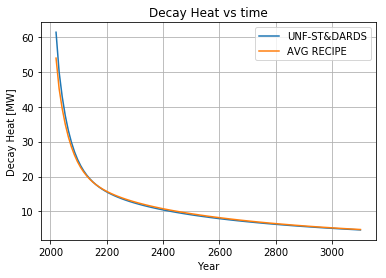

<function matplotlib.pyplot.close>

In [50]:
plt.plot(time_acc, heat_acc, label='UNF-ST&DARDS')
plt.plot(time_rec, heat_rec, label='AVG RECIPE')
plt.title('Decay Heat vs time')
plt.xlabel('Year')
plt.ylabel('Decay Heat [MW]')
plt.legend()
plt.grid()
plt.savefig('./images/heat.png', format='png')
plt.show()
plt.close

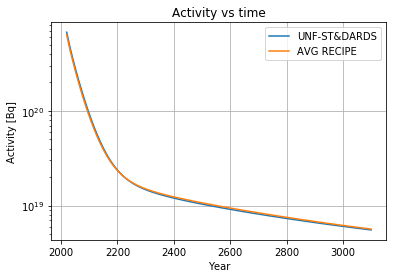

<function matplotlib.pyplot.close>

In [51]:
plt.semilogy(time_acc, act_acc, label='UNF-ST&DARDS')
plt.semilogy(time_rec, act_rec, label='AVG RECIPE')
plt.title('Activity vs time')
plt.xlabel('Year')
plt.ylabel('Activity [Bq]')
plt.legend()
plt.grid()
plt.savefig('./images/activity.png', format='png')
plt.show()
plt.close

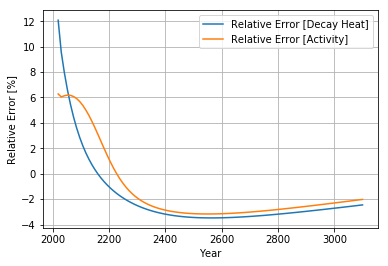

In [52]:
plt.plot(time_acc, err_heat, label='Relative Error [Decay Heat]')
plt.plot(time_acc, err_act, label='Relative Error [Activity]')
plt.xlabel('Year')
plt.ylabel('Relative Error [%]')
plt.legend()
plt.grid()
plt.savefig('./images/ha_err.png', format='png')
plt.show()
plt.close()

# Compare isotopic differences

In [353]:
def compare_isotope(acc_mat, rec_mat, isotope_list, rel_err=False):
    # convert to canonical / pyne-standard form
    isotope_list = [nucname.id(x) for x in isotope_list]
    iso_diff_dict = {}
    for iso in isotope_list:
        acc_qty = acc_mat.mult_by_mass()[iso]
        rec_qty = rec_mat.mult_by_mass()[iso]
        if rel_err:
            iso_diff_dict[nucname.name(iso)] = (acc_qty - rec_qty) / acc_qty * 100
        else:
            iso_diff_dict[nucname.name(iso)] = (acc_qty - rec_qty) * 1e-6
    return iso_diff_dict

def compare_element(acc_mat, rec_mat, zz_list, rel_err=False):
    el_diff_dict = {}
    for zz in zz_list:
        acc_qty = 0
        rec_qty = 0
        for key, val in acc_mat.mult_by_mass().items():
            if key // 10000000 == zz:
                acc_qty += acc_mat.mult_by_mass()[key]
                rec_qty += rec_mat.mult_by_mass()[key]
        if rel_err:
            el_diff_dict[zz] = (acc_qty - rec_qty) / acc_qty * 100
        else:
            el_diff_dict[zz] = acc_qty - rec_qty
    return el_diff_dict

def get_fissile_eq(mat, thermal=False):
    # from plutonium fuel - an assessment (NEA)
    eq = 0
    if thermal:
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (-1.0)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (-0.4)
        eq += mat.mult_by_mass()[942410000] * (1.3)
        eq += mat.mult_by_mass()[942420000] * (-1.4)
        eq += mat.mult_by_mass()[952410000] * (-2.2)
    else:
        # fast spectrum (super-phenix)
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (0.44)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (0.14)
        eq += mat.mult_by_mass()[942410000] * (1.5)
        eq += mat.mult_by_mass()[942420000] * (0.037)
        eq += mat.mult_by_mass()[952410000] * (-0.33)
    return eq

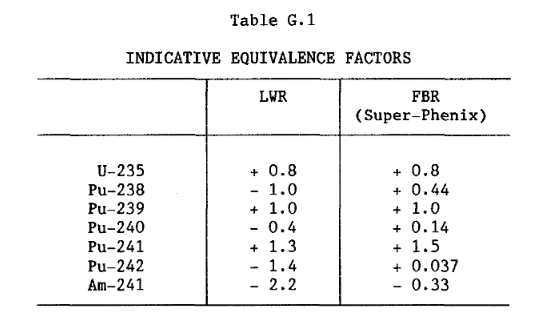

In [354]:
# Pu equiv factor from plutonium fuels (NEA)
from IPython.display import Image
Image('./images/pu_equiv.png')

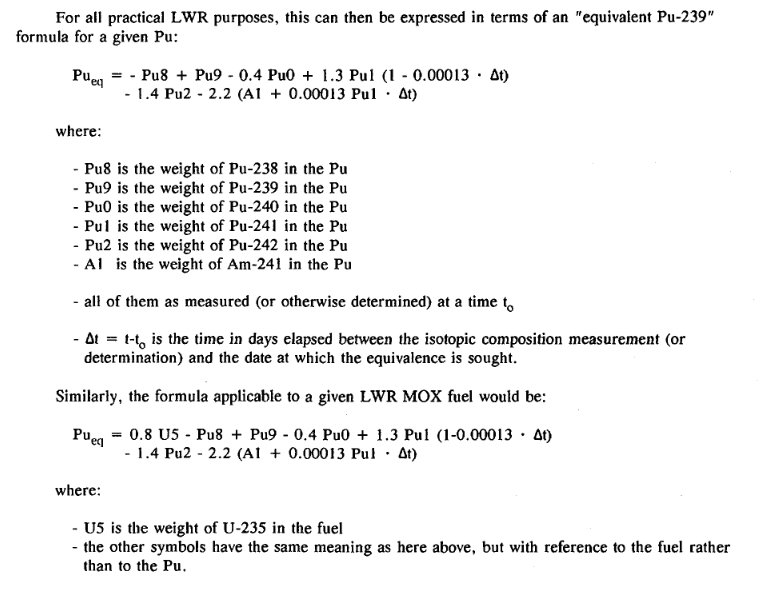

In [355]:
Image('./images/pu_equiv_eq.png')

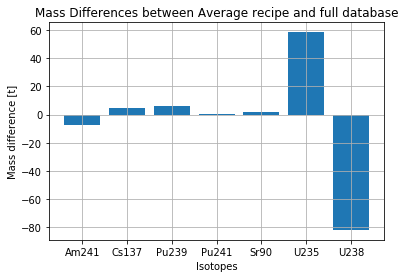

In [362]:
iso_list = ['Pu239', 'U238', 'U235', 'Am241', 'Cs137', 'Sr90', 'Pu241']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list)
plt.bar(iso_diff_dict.keys(), iso_diff_dict.values())
plt.grid()
plt.ylabel('Mass difference [t]')
plt.xlabel('Isotopes')
plt.title('Mass Differences between Average recipe and full database')
plt.savefig('./images/iso_mass.png', format='png')
plt.show()
plt.close()

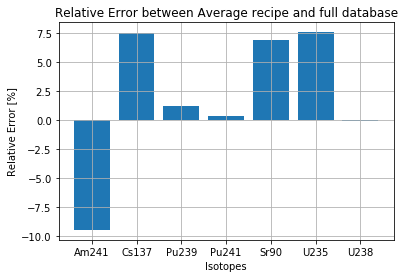

In [361]:
iso_list = ['Pu239', 'U238', 'U235', 'Am241', 'Cs137', 'Sr90', 'Pu241']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list, rel_err=True)
plt.bar(iso_diff_dict.keys(), iso_diff_dict.values())
plt.grid()
plt.ylabel('Relative Error [%]')
plt.xlabel('Isotopes')
plt.title('Relative Error between Average recipe and full database')
plt.savefig('./images/iso_rel.png', format='png')
plt.show()
plt.close()

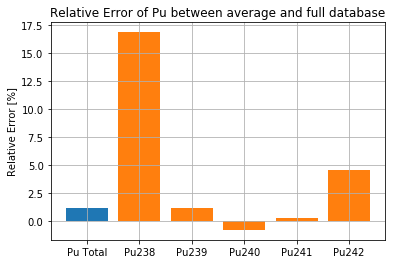

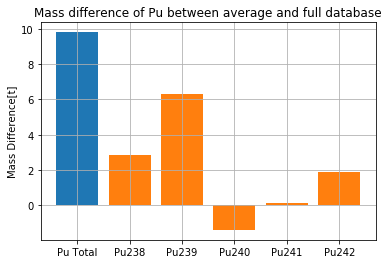

In [365]:
zz_list = [94]
el_diff_dict = compare_element(decayed_lump_mat, decayed_recipe_mat, zz_list, rel_err=True)
plt.bar(['Pu Total'], [el_diff_dict[94]])

iso_list = ['Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list, rel_err=True)

plt.bar(iso_diff_dict.keys(), iso_diff_dict.values())
plt.grid()
plt.ylabel('Relative Error [%]')
plt.title('Relative Error of Pu between average and full database')
plt.savefig('./images/pu_rel.png', format='png')
plt.show()
plt.close()

# actual mass difference
zz_list = [94]
el_diff_dict = compare_element(decayed_lump_mat, decayed_recipe_mat, zz_list, rel_err=False)
plt.bar(['Pu Total'], [el_diff_dict[94] * 1e-6])

iso_list = ['Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list, rel_err=False)

plt.bar(iso_diff_dict.keys(), np.array(list(iso_diff_dict.values())))
plt.grid()
plt.ylabel('Mass Difference[t]')
plt.title('Mass difference of Pu between average and full database')
plt.savefig('./images/pu_mass.png', format='png')
plt.show()
plt.close()

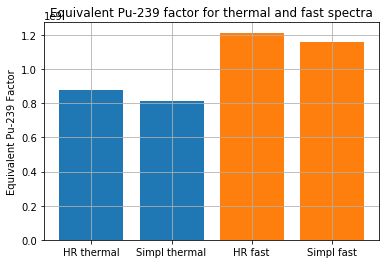

880.5953510527711
816.4789913324744
1214.0691471640257
1157.3605652658994


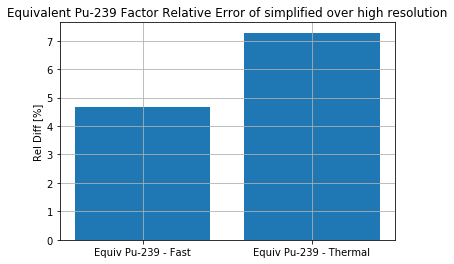

7.281024098485656
4.670951570641042


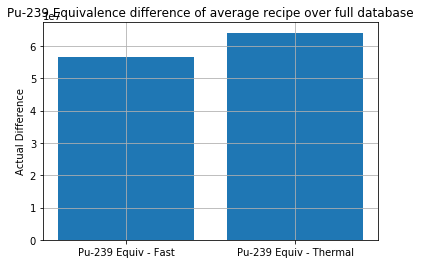

In [369]:
# eff pu241 for thermal and fast


acc_eq_thermal = get_fissile_eq(decayed_lump_mat, True)
acc_eq_fast = get_fissile_eq(decayed_lump_mat, False)
rec_eq_thermal = get_fissile_eq(decayed_recipe_mat, True)
rec_eq_fast = get_fissile_eq(decayed_recipe_mat, False)

rel_err_thermal = (acc_eq_thermal - rec_eq_thermal) / acc_eq_thermal * 100
rel_err_fast = (acc_eq_fast - rec_eq_fast) / acc_eq_fast * 100

plt.bar(['HR thermal', 'Simpl thermal'], [acc_eq_thermal, rec_eq_thermal])
plt.bar(['HR fast', 'Simpl fast'], [acc_eq_fast, rec_eq_fast])
plt.grid()
plt.ylabel('Equivalent Pu-239 Factor')
plt.title('Equivalent Pu-239 factor for thermal and fast spectra')
plt.savefig('./images/equiv_all.png', format='png')
plt.show()
plt.close()

print(acc_eq_thermal *1e-6)
print(rec_eq_thermal*1e-6)
print(acc_eq_fast*1e-6)
print(rec_eq_fast*1e-6)

plt.bar(['Equiv Pu-239 - Thermal', 'Equiv Pu-239 - Fast'], [rel_err_thermal, rel_err_fast])
plt.grid()
plt.ylabel('Rel Diff [%]')
plt.title('Equivalent Pu-239 Factor Relative Error of simplified over high resolution')
plt.savefig('./images/equiv_rel.png', format='png')
plt.show()
plt.close()

print(rel_err_thermal)
print(rel_err_fast)

plt.bar(['Pu-239 Equiv - Thermal', 'Pu-239 Equiv - Fast'], [acc_eq_thermal - rec_eq_thermal, acc_eq_fast - rec_eq_fast])
plt.grid()
plt.ylabel('Actual Difference')
plt.title('Pu-239 Equivalence difference of average recipe over full database')
plt.show()
plt.close()

In [215]:
# explain why there's not a difference in pu
# -> Pu 'saturates' after certain burnup and does not accumulate because it burns

# plot total pu diff
# plot pu quality diff

# fissile equivalenct (josh sent me a paper - pg120)
# find `Equivalent pu' (pg120)

# fuel that are older have more decay
# fuel that are younger have less time to decay

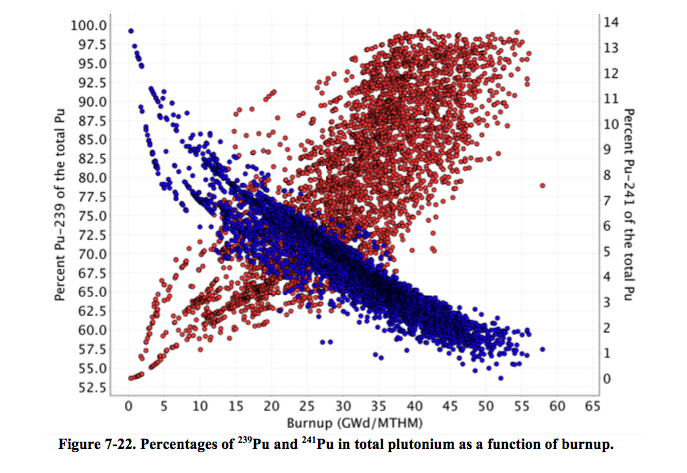

In [227]:
# from UNF-ST&DARDS report, Joshua Peterson-Droogh
# red (Pu239), blue(Pu241)
Image("./imgaes/pu_burnup.png")

In [290]:
# get assembly_isotope_data
assem_dict = {}
total_mass = cur.execute('SELECT assembly_id, sum(total_mass_g), initial_enrichment, discharge_burnup '
                         'FROM discharge GROUP BY assembly_id').fetchall()
for row in total_mass:
    assem_dict[row['assembly_id']] = {'mass': row['sum(total_mass_g)'], 'comp': {}}
    assem_dict[row['assembly_id']]['burnup'] = float(row['discharge_burnup']) * 1e-3
    assem_dict[row['assembly_id']]['enrichment'] = float(row['initial_enrichment'])
    

In [291]:
isotopes = cur.execute('SELECT assembly_id, isotope, total_mass_g FROM discharge WHERE '
                        'isotope LIKE "pu%" OR isotope LIKE "u-235" OR isotope LIKE "am-241"').fetchall()
for row in isotopes:
    assem_dict[row['assembly_id']]['comp'][row['isotope']] = float(row['total_mass_g']) / float(assem_dict[row['assembly_id']]['mass'])

In [292]:
def attach_equiv(assem_dict):
    for key, value in assem_dict.items():
        ther_equiv = 0
        fast_equiv = 0
        for key2, value2 in value['comp'].items():
            if key2 == 'u-235':
                ther_equiv += value2 * 0.8
                fast_equiv += value2 * 0.8
            elif key2 == 'pu-238':
                ther_equiv -= value2 * 1.0
                fast_equiv += value2 * 0.44
            elif key2 == 'pu-239':
                ther_equiv += value2 * 1.0
                fast_equiv += value2 * 1.0
            elif key2 == 'pu-240':
                ther_equiv -= value2 * 0.4
                fast_equiv += value2 * 0.14
            elif key2 == 'pu-241':
                ther_equiv += value2 * 1.3
                fast_equiv += value2 * 1.5
            elif key2 == 'pu-242':
                ther_equiv -= value2 * 1.4
                fast_equiv += value2 * 0.037
            elif key2 == 'am-241':
                ther_equiv -= value2 * 2.2
                fast_equiv -= value2 * 0.33
            elif key2 == 'pu-244':
                # do nothing
                z=0
            else:
                print('THE UNCOUNTED ISOTOPE IS: %s' %key2)
        assem_dict[key]['fast_equiv'] = fast_equiv
        assem_dict[key]['thermal_equiv'] = ther_equiv
    return assem_dict

In [293]:
assem_dict = attach_equiv(assem_dict)

In [294]:
er = []
bu = []
fast_eq = []
thermal_eq = []
for key, val in assem_dict.items():
    er.append(val['enrichment'])
    bu.append(val['burnup'])
    fast_eq.append(val['fast_equiv'])
    thermal_eq.append(val['thermal_equiv'])

In [316]:
print('Pu239 Equivalance Factor for Average Comp\n')
print('Fast:')
print(assem_dict[324192]['fast_equiv'])
print('Thermal:')
print(assem_dict[324192]['thermal_equiv'])

Pu239 Equivalance Factor for Average Comp

Fast:
0.01900630500238818
Thermal:
0.015726138809854837


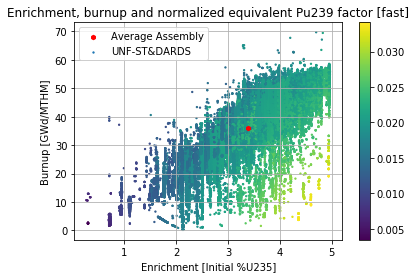

In [370]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=fast_eq, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and normalized equivalent Pu239 factor [fast]')
plt.colorbar()
plt.savefig('./images/fast_all.png', format='png')
plt.show()
plt.close()

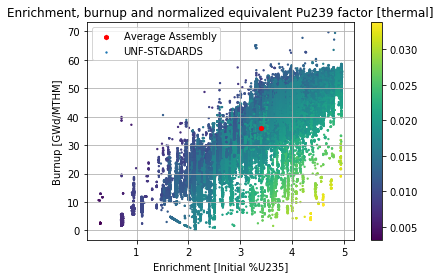

In [371]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=thermal_eq, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and normalized equivalent Pu239 factor [thermal]')
plt.colorbar()
plt.savefig('./images/thermal_all.png', format='png')
plt.show()
plt.close()

In [13]:
# get assembly_isotope_data
assem_dict = {}
total_mass = cur.execute('SELECT assembly_id, sum(total_mass_g), initial_enrichment, discharge_burnup '
                         'FROM discharge GROUP BY assembly_id').fetchall()
for row in total_mass:
    assem_dict[row['assembly_id']] = {'mass': row['sum(total_mass_g)'], 'comp': {}}
    assem_dict[row['assembly_id']]['burnup'] = float(row['discharge_burnup']) * 1e-3
    assem_dict[row['assembly_id']]['enrichment'] = float(row['initial_enrichment'])
    

In [14]:
isotopes = cur.execute('SELECT assembly_id, isotope, total_mass_g FROM discharge WHERE '
                        'isotope LIKE "cs-137" OR isotope LIKE "sr-90" OR isotope LIKE "am-241"').fetchall()
for row in isotopes:
    assem_dict[row['assembly_id']]['comp'][row['isotope']] = float(row['total_mass_g']) / float(assem_dict[row['assembly_id']]['mass'])

In [15]:
def attach_cs_sr_am(assem_dict):
    for key, value in assem_dict.items():
        cs = 0
        sr = 0
        am = 0
        for key2, value2 in value['comp'].items():
            if key2 == 'cs-137':
                cs += value2
            if key2 == 'sr-90':
                sr += value2
            if key2 == 'am-241':
                am += value2
        assem_dict[key]['cs'] = cs
        assem_dict[key]['sr'] = sr
        assem_dict[key]['am'] = am
    return assem_dict

In [16]:
assem_dict = attach_cs_sr_am(assem_dict)

In [17]:
er = []
bu = []
cs = []
sr = []
am = []
for key, val in assem_dict.items():
    er.append(val['enrichment'])
    bu.append(val['burnup'])
    cs.append(val['cs'])
    sr.append(val['sr'])
    am.append(val['am'])

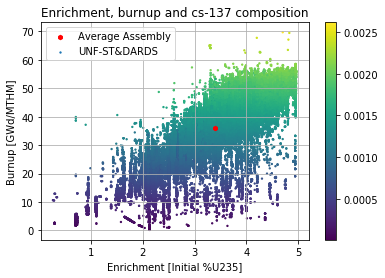

In [18]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=cs, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and cs-137 composition')
plt.colorbar()
plt.show()
plt.close()

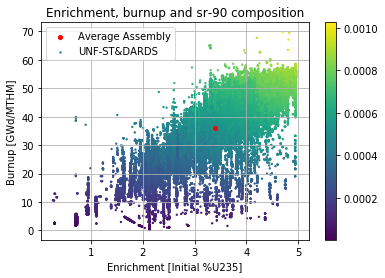

In [19]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=sr, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and sr-90 composition')
plt.colorbar()
plt.show()
plt.close()

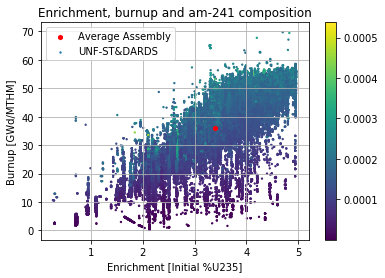

In [20]:
plt.scatter([3.39204], [36.16938], label='Average Assembly', color='red', marker='h', s = 20, zorder=1)
plt.scatter(er, bu, c=am, marker='.', zorder=-1, label='UNF-ST&DARDS', s=7)
plt.grid()
plt.xlabel('Enrichment [Initial %U235]')
plt.legend()
plt.ylabel('Burnup [GWd/MTHM]')
plt.title('Enrichment, burnup and am-241 composition')
plt.colorbar()
plt.show()
plt.close()

In [ ]:
3*